In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import textwrap
from umap import UMAP
import datapane as dp
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve
import scikitplot as skplt
from tqdm import tqdm

sns.set_style('whitegrid')
%matplotlib inline

from custom_functions import *

tqdm.pandas()

C:\Users\adshafi\Anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
import gensim
import gensim.models as g
import gensim.downloader
import pickle
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English

In [3]:
X_train = pd.read_pickle('./pickled_data/X_train.pkl')
X_test = pd.read_pickle('./pickled_data/X_test.pkl')
y_train = pd.read_pickle('./pickled_data/y_train.pkl')
y_test = pd.read_pickle('./pickled_data/y_test.pkl')

In [4]:
### Pretrained Word2Vec can only process words inside its vocabulary. 
# This won't include the tags we created for URL or at_user
# It also doesn't understand most punctuation (apart from @)

X_train['text'] = (X_train['text']
                    .str.replace('\n',' ', regex=False)
                    .str.replace("[^/s ^a-zA-Z ^\[\]]", "") # underscore removed bt previous step
                    .str.replace('[ATUSER]','@', regex=False)
                    .str.replace('[URL]','url', regex=False)
                    .str.strip())


X_test['text'] = (X_test['text']
                    .str.replace('\n',' ', regex=False)
                    .str.replace("[^/s ^a-zA-Z ^\[\]]", "") 
                    .str.replace('[ATUSER]','@', regex=False) # underscore removed bt previous step
                    .str.replace('[URL]','url', regex=False)
                    .str.strip())

### Word2Vec

100%|██████████| 1521/1521 [03:31<00:00,  7.18it/s]


Publishing report and associated data - please wait..


C:\Users\adshafi\Anaconda3\lib\site-packages\datapane\client\api\report\core.py:249: UserWarning:

Passing visibility as a string is deprecated, use dp.Visibility enum instead.



Report successfully published at https://datapane.com/u/adam1/reports/word2vec-vectors/
Publishing report and associated data - please wait..
Report successfully published at https://datapane.com/u/adam1/reports/word2vec-model/


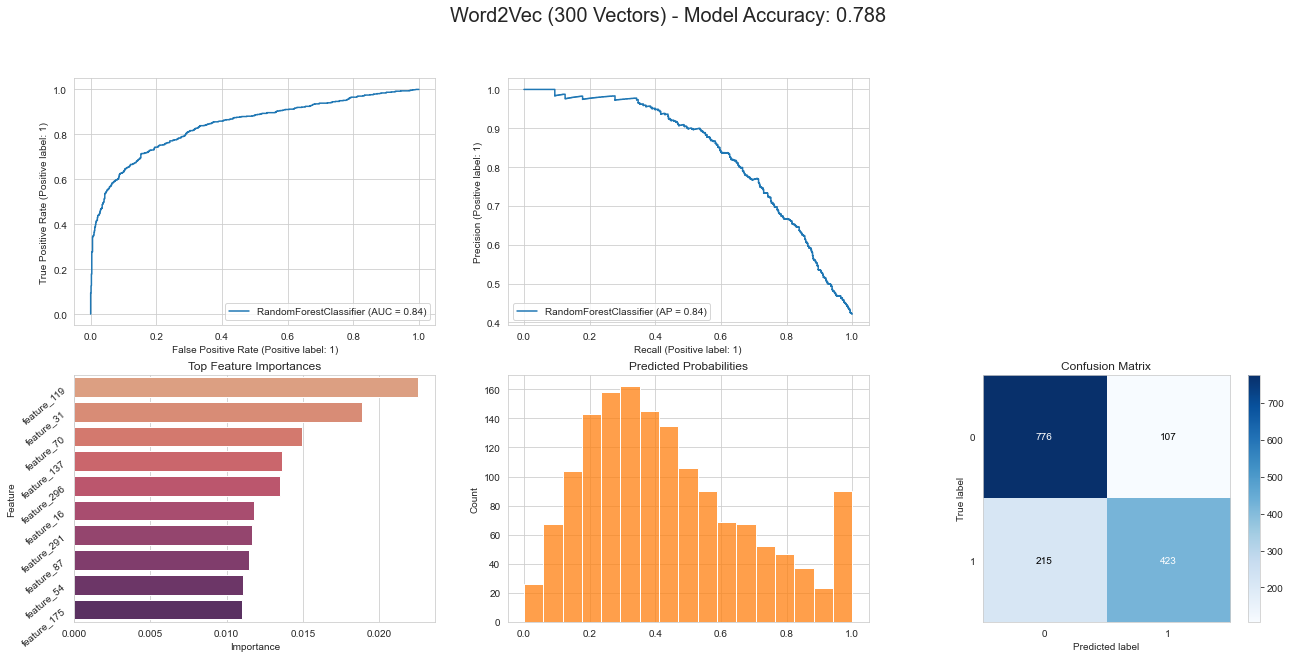

In [5]:
### Download the model from Gensim and save locally

#word2vec = gensim.downloader.load('word2vec-google-news-300') #1.66 gb
#pickle.dump(word2vec, open('w2v', 'wb'))

### Load pickled file if already saved

word2vec = pickle.load(open('w2v', 'rb'))


# vectorize the data

X_train_vec = pd.DataFrame(np.vstack(X_train['text'].progress_apply(vectorize_sentence, model=word2vec)))
X_test_vec = pd.DataFrame(np.vstack(X_test['text'].progress_apply(vectorize_sentence, model=word2vec)))

cols = [f'feature_{i}' for i in range(X_train_vec.shape[1])] # Word2Vec doesn't have feature names

# to get a dataframe

X_train_df = pd.DataFrame(X_train_vec)
X_train_df.columns = cols

# fit a random forest model

model = RandomForestClassifier(n_estimators=500, n_jobs=8)
model.fit(X_train_vec,y_train)
model_plot = model_summary_plot(model, X_test_vec, y_test, cols,
                                f'Word2Vec ({X_train_df.shape[1]} Vectors)',
                                model.feature_importances_,n=10)


dp_publish(umap_plot(X_train, y_train, X_train_df),'Word2Vec Vectors')

dp_publish(model_plot,'Word2Vec Model')

### GLoVe

  0%|          | 6/6081 [00:00<13:08,  7.71it/s]C:\Users\adshafi\jupyter_notebooks\exploring_embeddings\disaster_recognition\custom_functions.py:62: RuntimeWarning:

Mean of empty slice.

100%|██████████| 1521/1521 [03:29<00:00,  7.26it/s]


Publishing report and associated data - please wait..


C:\Users\adshafi\Anaconda3\lib\site-packages\datapane\client\api\report\core.py:249: UserWarning:

Passing visibility as a string is deprecated, use dp.Visibility enum instead.



Report successfully published at https://datapane.com/u/adam1/reports/glove-vectors/
Publishing report and associated data - please wait..
Report successfully published at https://datapane.com/u/adam1/reports/glove-model/


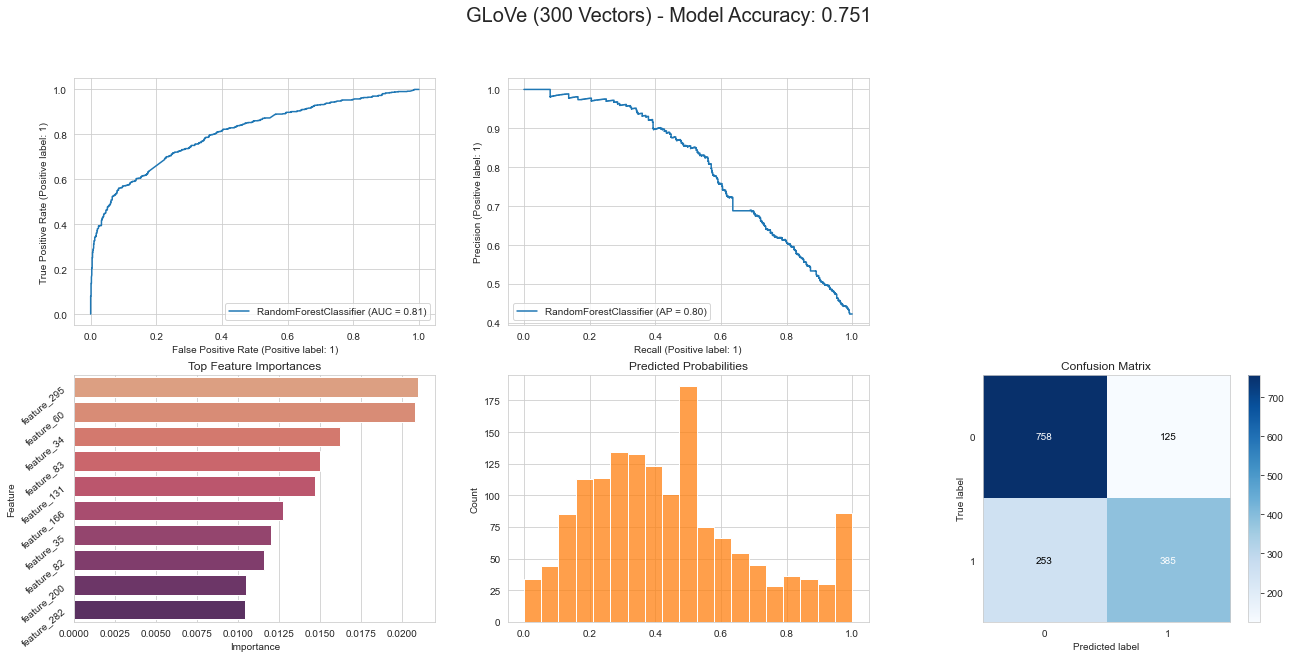

In [6]:
### Download the model from Gensim and save locally

#gv = gensim.downloader.load('glove-wiki-gigaword-300') #376mb
#pickle.dump(gv, open('gv', 'wb'))

### Load pickled file if already saved

gv = pickle.load(open('gv', 'rb'))


# vectorize the data

X_train_vec = pd.DataFrame(np.vstack(X_train['text'].progress_apply(vectorize_sentence, model=gv)))
X_test_vec = pd.DataFrame(np.vstack(X_test['text'].progress_apply(vectorize_sentence, model=gv)))

cols = [f'feature_{i}' for i in range(X_train_vec.shape[1])] # Word2Vec doesn't have feature names

# to get a dataframe

X_train_df = pd.DataFrame(X_train_vec)
X_train_df.columns = cols

# fit a random forest model

model = RandomForestClassifier(n_estimators=500, n_jobs=8)
model.fit(X_train_vec,y_train)
model_plot = model_summary_plot(model, X_test_vec, y_test, cols,
                                f'GLoVe ({X_train_df.shape[1]} Vectors)',
                                model.feature_importances_,n=10)


dp_publish(umap_plot(X_train, y_train, X_train_df),'GLoVe Vectors')

dp_publish(model_plot,'GLoVe Model')

### Doc2Vec

100%|██████████| 1521/1521 [00:01<00:00, 1255.28it/s]


Publishing report and associated data - please wait..


C:\Users\adshafi\Anaconda3\lib\site-packages\datapane\client\api\report\core.py:249: UserWarning:

Passing visibility as a string is deprecated, use dp.Visibility enum instead.



Report successfully published at https://datapane.com/u/adam1/reports/doc2vec-vectors/
Publishing report and associated data - please wait..
Report successfully published at https://datapane.com/u/adam1/reports/doc2vec-model/


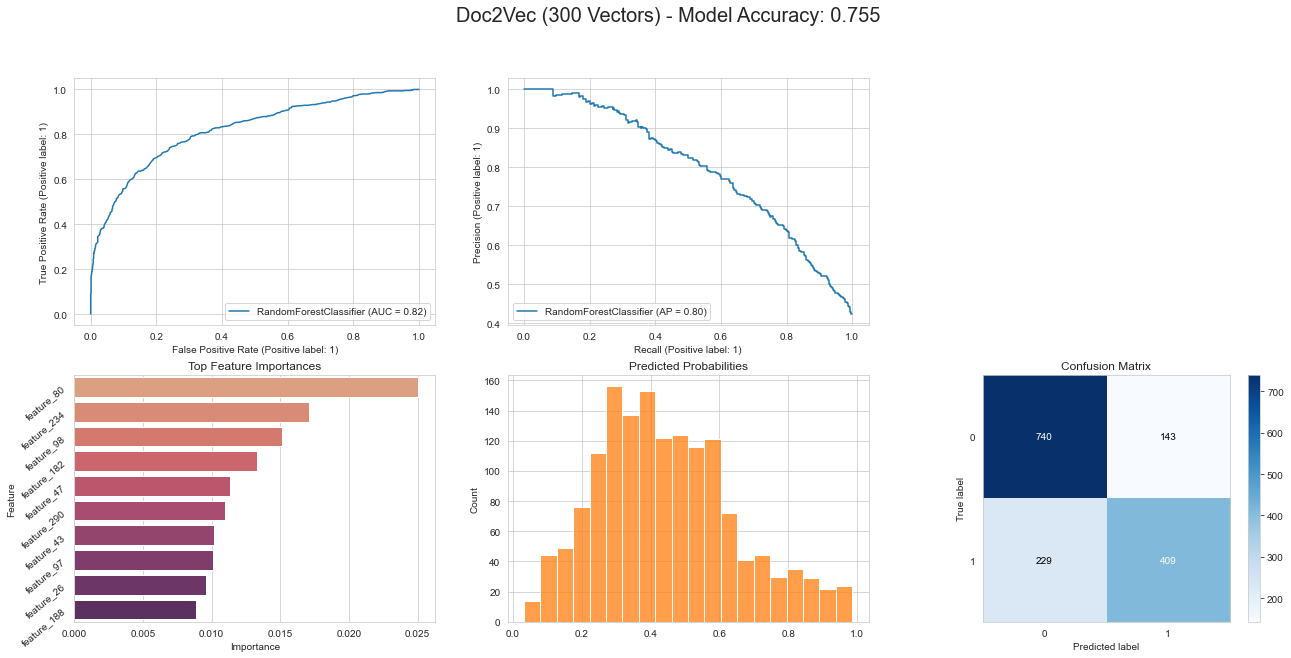

In [7]:
# Model downloaded from https://ai.intelligentonlinetools.com/ml/text-clustering-doc2vec-word-embedding-machine-learning/
#https://ibm.ent.box.com/s/3f160t4xpuya9an935k84ig465gvymm2

# Load unzipped model, saved locally
model="../doc2vec/doc2vec.bin"
m = g.Doc2Vec.load(model)

# Instantiate SpaCy Tokenizer
nlp = English()
tokenizer = Tokenizer(nlp.vocab)

# Loop Through texts and create vectors

a=[]
for text in tqdm(X_train['text']):
    a.append(m.infer_vector([str(word) for word in tokenizer(text)]))
    
X_train_vec = pd.DataFrame(np.array(a))
    
a=[]
for text in tqdm(X_test['text']):
    a.append(m.infer_vector([str(word) for word in tokenizer(text)]))
    
X_test_vec = pd.DataFrame(np.array(a))

a=None # clear variable for memory

cols = [f'feature_{i}' for i in range(X_train_vec.shape[1])] # Word2Vec doesn't have feature names

# to get a dataframe

X_train_df = pd.DataFrame(X_train_vec)
X_train_df.columns = cols

# fit a random forest model

model = RandomForestClassifier(n_estimators=500, n_jobs=8)
model.fit(X_train_vec,y_train)
model_plot = model_summary_plot(model, X_test_vec, y_test, cols,
                                f'Doc2Vec ({X_train_df.shape[1]} Vectors)',
                                model.feature_importances_,n=10)

dp_publish(umap_plot(X_train, y_train, X_train_df),'Doc2Vec Vectors')

dp_publish(model_plot,'Doc2Vec Model')